In [1]:
!pip install matplotlib==3.5.0

In [2]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import csv
import math
import pickle
import matplotlib.pyplot as plt
import os
from IPython.display import HTML
from base64 import b64encode
import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')
db_path = '/content/drive/MyDrive/Emotion/ELEA'

Mounted at /content/drive


In [4]:
current_directory = os.getcwd()

In [5]:
!mkdir {current_directory}/UMAP_plots/
!mkdir {current_directory}/UMAP_self_report_plots/
!mkdir {current_directory}/stability_plasticity/
!mkdir {current_directory}/stability_plasticity/extra

# OCEAN

https://community.plotly.com/t/subplot-with-shared-x-axis-and-range-slider/3148

In [6]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

def generate_order(group_id, elea_labels):
  ordering = []
  for label in elea_labels:
    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_O.pkl', 'rb') as f:
      ordering.append(np.nansum(pickle.load(f)['traj_mask_active_speaker_min20']))

  elea_labels_ordered = [elea_labels[i] for i in argsort(ordering)]
  return elea_labels_ordered[::-1]

In [7]:
def read_speaker_segmentation(file: str):
    active_speakers = []
    with open(file, newline='') as f:
        reader = csv.reader(f, delimiter=',')
        i = 0
        for row in reader:
            i += 1
            if i == 1: continue
            active_speakers.append((float(row[0]), float(row[1]), row[2]))
    return active_speakers

def get_active_speaker(active_speakers: list, t: float):
    # timestamp in seconds, labels appear only once
    # returns speaker ids for all speakers speaking at a given timestamp
    return list(set([elem[2] for elem in active_speakers if t >= elem[0] and t < elem[1]]))

def get_active_speaker_annotation(active_speakers):
    length = int(np.array([elem[1] for elem in active_speakers]).max())
    ids = sorted(list(set([elem[2] for elem in active_speakers])))
    print(ids)
    lines = np.zeros(shape=(len(ids), length), dtype=bool)
    for i in range(length):
        a = get_active_speaker(active_speakers, i)
        for id in a:
            lines[ids.index(id), i] = True
    return lines, ids

def return_mask(active_speaker_annotation, ids, id):
    active_idx = ids.index(id)
    mask = active_speaker_annotation[active_idx, :]
    return mask


In [ ]:
fig = make_subplots(          
            rows=2, cols=1, 
            subplot_titles=('Title 1', 'Title 2'),
            vertical_spacing=0.3   
   
)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")


fig.add_trace(go.Scatter(x=df.Date, y=df['AAPL.High'], name="AAPL High",
                         line_color='deepskyblue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['AAPL.Low'], name="AAPL Low",
                         line_color='dimgray'), row=1, col=1)

fig.add_trace(go.Bar(y=np.random.randint(3,9, 11)), row=2, col=1)
fig.update_layout(title_text='Global title',
                  xaxis_rangeslider_visible=True,
                  height=600)
fig.show()

In [8]:
def return_masked_ponts(group_id):

  for x in os.listdir(f"{db_path}/ELEA_SpeakingSegmentation"):
    if x.split("_")[-1] == f"G{group_id}.csv":
      csv_file = x
  try:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}")
  except:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}", skiprows=2)

  elea_labels = identity_df['person'].unique()

  average_df = {}
  speaking_points = {}
  for label in elea_labels:
    speaker_data_raw = []
    for OCEAN_label in ['O', 'C', 'E','A','N']:
      with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
        speaker_data_raw.append(pickle.load(f)['wins_preds'])
    speaker_data = np.hstack(speaker_data_raw)

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      v_stat_success = pickle.load(f)['wins_v_stat_success']

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      talking_point = pickle.load(f)['traj_mask_active_speaker_min20']

    
   
    speaker_df = identity_df.loc[identity_df['person'] == label]
    average = np.zeros(5)
    # points = np.array([])
    points = []
    num_data_pts = 0

    for index, row in enumerate(speaker_data):
      if v_stat_success[index] >= 0.6 and talking_point[index] == True:
        points.append(row)
      else:
        points.append(np.zeros(5))

    speaking_points[label] = np.vstack(points)
    
  return speaking_points

In [9]:
def plot_OCEAN(group_id, OCEAN_label):

  for x in os.listdir(f"{db_path}/ELEA_SpeakingSegmentation"):
    if x.split("_")[-1] == f"G{group_id}.csv":
      csv_file = x
  try:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}")
  except:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}", skiprows=2)

  elea_labels = identity_df['person'].unique()

  Tot = len(elea_labels)
  Cols = 1
  # Compute Rows requires
  Rows = Tot // Cols 
  Rows += Tot % Cols
  # Create a Position index
  Position = range(1,Tot + 1)
  titles=("K", "L", "M", "N")
  fig = make_subplots(rows=Rows, cols=1, vertical_spacing=0.2,shared_xaxes=True, subplot_titles=titles)


  speaker_ordering =  generate_order(group_id, elea_labels)
  masked_points_dict = return_masked_ponts(group_id)
  for speaker_idx, speaker in enumerate(speaker_ordering):
    # speaker_data_raw = []
    # with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{speaker}_{OCEAN_label}.pkl', 'rb') as f:
    #   speaker_data_raw.append(pickle.load(f)['wins_preds'])

    # speaker_data = [x[0] for x in speaker_data_raw[0]]

    speaker_data = masked_points_dict[speaker][:,0]

    fig.add_trace(go.Scatter(x=list(range(len(speaker_data)-3)), y=speaker_data[4:], mode='lines'),row=Position[speaker_idx], col=1) 

  # fig.update_layout(xaxis=dict(rangeselector=dict(buttons=list([dict(count=1,step="all",stepmode="backward"),])),rangeslider=dict(visible=True),))
  if len(speaker_ordering) == 4:
    fig.update_layout(height=700, width=600, legend_orientation="h", xaxis4_rangeslider_visible=True, xaxis4_rangeslider_thickness=0.1, title_text="O Attribute")
  else:
    fig.update_layout(height=700, width=600, legend_orientation="h", xaxis3_rangeslider_visible=True, xaxis3_rangeslider_thickness=0.1, title_text="O Attribute")

  fig.show()





In [ ]:
plot_OCEAN(34, 'O')

In [ ]:

import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

In [ ]:
# Create figure for one trait in the OCEAN trajectory 

active_speakers = read_speaker_segmentation(seg_file)
speaker_lines, ids = get_active_speaker_annotation(active_speakers)
mask = return_mask(speaker_lines,ids,speaker_id)

if delay > 0:
  delay = math.ceil(delay)
  delay_array = np.zeros((delay,), dtype=bool)
  mask = np.concatenate((delay_array, mask))
if delay < 0:
  delay = np.abs(math.floor(delay))
  delay_array = np.zeros((delay,), dtype=bool)
  mask = np.concatenate((mask[delay:], delay_array))

if mask.size > len(x):
    mask = mask[:len(x)]
if mask.size < len(x):
    x = x[:mask.size]

y = list(G12_1_left_pd.O * mask)


plot = go.Figure(data=[go.Scatter(
	x=x,
	y=y,
	mode='lines',)
])

plot.update_layout(
	xaxis=dict(
		rangeselector=dict(
			buttons=list([
				dict(count=1,
					step="all",
					stepmode="backward"),
			])
		),
		rangeslider=dict(
			visible=True
		),
	)
)

plot.show()


# Deviations

In [10]:
def get_personality_average(group_id):

  for x in os.listdir(f"{db_path}/ELEA_SpeakingSegmentation"):
    if x.split("_")[-1] == f"G{group_id}.csv":
      csv_file = x
  try:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}")
  except:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}", skiprows=2)

  elea_labels = identity_df['person'].unique()

  average_df = {}
  speaking_points = {}
  for label in elea_labels:
    speaker_data_raw = []
    for OCEAN_label in ['O', 'C', 'E','A','N']:
      with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
        speaker_data_raw.append(pickle.load(f)['wins_preds'])
        
    speaker_data = np.hstack(speaker_data_raw)

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      v_stat_success = pickle.load(f)['wins_v_stat_success']

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      talking_point = pickle.load(f)['traj_mask_active_speaker_min20']

    
   
    speaker_df = identity_df.loc[identity_df['person'] == label]
    average = np.zeros(5)
    # points = np.array([])
    points = []
    num_data_pts = 0

    for index, row in enumerate(speaker_data):
      if v_stat_success[index] >= 0.6 and talking_point[index] == True:
        points.append(row)

    average_df[label] = np.mean(np.vstack(points), axis=0)
    speaking_points[label] = np.vstack(points)
    
  return average_df, speaking_points

In [11]:
def temporal_changes(group_id):

  for x in os.listdir(f"{db_path}/ELEA_SpeakingSegmentation"):
    if x.split("_")[-1] == f"G{group_id}.csv":
      csv_file = x
  try:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}")
  except:
    identity_df = pd.read_csv(f"{db_path}/ELEA_SpeakingSegmentation/{csv_file}", skiprows=2)

  elea_labels = identity_df['person'].unique()

  total_points = {}
  v_stat = {}
  talking_mask = {}

  for label in elea_labels:
    speaker_data_raw = []
    for OCEAN_label in ['O', 'C', 'E','A','N']:
      with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
        speaker_data_raw.append(pickle.load(f)['wins_preds'])
    speaker_data = np.hstack(speaker_data_raw)

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      v_stat_success = pickle.load(f)['wins_v_stat_success']

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      talking_point = pickle.load(f)['traj_mask_active_speaker_min20']
    
    total_points[label] = speaker_data
    v_stat[label] = v_stat_success
    talking_mask[label] = talking_point

  averages, _ = get_personality_average(group_id)

  abs_sum_changes = []
  largest_deviations = []

  for i in range(3):
    abs_sum_changes.append([0,0,0,0,0])
    largest_deviations.append([0,0,0,0,0])

  enumeration_points = list(range(total_points[list(total_points.keys())[0]].shape[0] - 3))

  for timestamp, value in enumerate(enumeration_points, start = 3):
    abs_sum_changes_row = []
    largest_deviation_row = []

    for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):

      changes = []
      for label in elea_labels:
        if v_stat[label][timestamp] >= 0.6 and talking_mask[label][timestamp] == True:
          changes.append(total_points[label][timestamp, OCEAN_idx] - averages[label][OCEAN_idx])
      if changes:
        abs_sum = np.sum(np.abs(np.array(changes)))
        largest_deviation = changes[np.argmax(np.abs(np.array(changes)))]

        abs_sum_changes_row.append(abs_sum)
        largest_deviation_row.append(largest_deviation)

    if abs_sum_changes_row:   
      abs_sum_changes.append(abs_sum_changes_row)
      largest_deviations.append(largest_deviation_row)
    else:
      abs_sum_changes.append([0,0,0,0,0])
      largest_deviations.append([0,0,0,0,0])

  return np.vstack(abs_sum_changes), np.stack(largest_deviations)


In [74]:
!mkdir {current_directory}/absolute_changes
!mkdir {current_directory}/largest_deviations

In [10]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]
for group in groups[:1]:
  abs, dev = temporal_changes(group)

  fig, axs = plt.subplots(5, 1)
  fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

  for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):
        axs[OCEAN_idx].plot(list(range(abs.shape[0])), abs[:, OCEAN_idx])

  plt.show()
  fig.savefig(f"{current_directory}/absolute_changes/abs_changes_{group}.jpg")
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

  fig, axs = plt.subplots(5, 1)
  fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

  for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):
        axs[OCEAN_idx].plot(list(range(dev.shape[0])), dev[:, OCEAN_idx])

  plt.show()
  fig.savefig(f"{current_directory}/largest_deviations/largest_deviation_{group}.jpg")
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

KeyboardInterrupt: ignored

# Visualize Deviations

In [12]:
def viz_temporal(group, OCEAN_idx, use_abs=True):
	abs, dev = temporal_changes(group)
	if use_abs:
		y = abs[:,OCEAN_idx]
	else:
		y = dev[:,OCEAN_idx]
	plot = go.Figure(data=[go.Scatter(
		x=list(range(abs.shape[0])),
		y=y,
		mode='lines',)
	])

	plot.update_layout(
		xaxis=dict(
			rangeselector=dict(
				buttons=list([
					dict(count=1,
						step="all",
						stepmode="backward"),
				])
			),
			rangeslider=dict(
				visible=True
			),
		)
	)

	plot.show()

In [ ]:
viz_temporal(39, 2, use_abs=True)

In [13]:
def viz_temporal_multiple(group_id):

  Tot = 5
  Cols = 1
  # Compute Rows requires
  Rows = Tot // Cols 
  Rows += Tot % Cols
  # Create a Position index
  Position = range(1,Tot + 1)
  titles=("O", "C", "E", "A", "N")
  fig = make_subplots(rows=Rows, cols=1, vertical_spacing=0.2,shared_xaxes=True, subplot_titles=titles)

  abs, dev = temporal_changes(group_id)

  for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):
    fig.add_trace(go.Scatter(x=list(range(abs.shape[0])), y=abs[:, OCEAN_idx], mode='lines'),row=Position[OCEAN_idx], col=1) 

  fig.update_layout(height=700, width=600, legend_orientation="h", xaxis5_rangeslider_visible=True, xaxis5_rangeslider_thickness=0.1, title_text=f"{group_id} Abs Changes")

  fig.show()

In [ ]:
viz_temporal_multiple(12)

# Compare Interruptions

In [14]:
def filter_list(myList, threshold = 4):
  usedValues = set()
  newList = []

  for v in myList:
      if v not in usedValues:
          newList.append(v)

          for lv in range(v - 6, v + 7):
              usedValues.add(lv)
  return newList

In [15]:
from itertools import zip_longest

def alternate(list1, list2):
    return [v for v in sum(zip_longest(list1, list2), ()) if v is not None]

In [16]:
def compare_to_interruptions(group_id):
  interruption_df = pd.read_csv(f'{db_path}/overlap_set_dur/{group_id}_overlap.csv')

  # abs, dev = temporal_changes(group_id)
  # peaks_unfiltered = np.argpartition(abs[:,2], -15)[-15:]
  # print(peaks_unfiltered.astype(int).tolist())
  # peaks = filter_list(peaks_unfiltered.astype(int).tolist())
  # # arr.argsort()[-3:][::-1]
  # print(peaks)
  # peak_inliers = np.zeros(len(peaks))
  # for index, row in interruption_df.iterrows():
  #   for peak_idx, peak in enumerate(peaks):
  #     if row['start'] + 3 <= peak <= row['end'] + 6:
  #       print(row['start'] + 3)
  #       print(peak)
  #       print(row['end'] + 6)
  #       peak_inliers[peak_idx] = 1
  #       break
  # print(peak_inliers)
  # return peak_inliers


  abs, dev = temporal_changes(group_id)
  peak_inliers = []
  for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):
    peaks_unfiltered = np.argpartition(abs[:,2], -30)[-30:]
    peaks = filter_list(peaks_unfiltered.astype(int).tolist())
    for index, row in interruption_df.iterrows():
      for peak_idx, peak in enumerate(peaks):
        if row['start'] + 3 <= peak <= row['end'] + 6:
          # print(row['start'] + 3)
          # print(peak)
          # print(row['end'] + 6)
          peak_inliers.append(peak)
          break
  agg_peaks = filter_list(peak_inliers)
  return agg_peaks
      


In [17]:
def return_filtered_peaks(group_id):
  abs, dev = temporal_changes(group_id)
  agg_peaks = {}
  for OCEAN_idx, OCEAN_label in enumerate(['O', 'C', 'E','A','N']):
    peaks_unfiltered = np.argpartition(abs[:,OCEAN_idx], -10)[-10:]
    peaks = filter_list(peaks_unfiltered.astype(int).tolist())
    agg_peaks[OCEAN_label] = peaks
  agg_peaks_sorted = alternate(alternate(alternate(alternate(agg_peaks['O'], agg_peaks['C']), agg_peaks['E']), agg_peaks['A']), agg_peaks['N'])
  peaks = filter_list(agg_peaks_sorted)
  return peaks, [str(datetime.timedelta(seconds=peak)) for peak in peaks]

In [ ]:
compare_to_interruptions(39)

In [ ]:
peaks, seconds = return_filtered_peaks(34)
print(peaks)
print(seconds)
print(len(seconds))

In [ ]:
['0:09:05', '0:12:04', '0:07:19', '0:02:39', '0:06:30', '0:08:53', '0:02:33', '0:08:14', '0:11:52', '0:05:07', '0:10:06', '0:10:49', '0:02:50', '0:11:01', '0:07:54', '0:03:45', '0:05:38', '0:04:05', '0:06:19', '0:08:05', '0:06:24', '0:07:14', '0:12:11', '0:11:24', '0:06:43', '0:05:57', '0:05:47', '0:03:51']

In [ ]:
a = ['0:09:05', '0:12:04', '0:07:19', '0:02:39', '0:06:30', '0:08:53', '0:02:33', '0:08:14', '0:11:52', '0:05:07', '0:10:06', '0:10:49', '0:02:50', '0:11:01', '0:07:54', '0:03:45', '0:05:38', '0:04:05', '0:06:19', '0:08:05', '0:06:24', '0:07:14']

In [ ]:
len(a)

In [ ]:
['0:07:18', '0:02:39', '0:06:30', '0:08:53', '0:02:33', '0:08:14', '0:03:45', '0:05:38', '0:04:05', '0:06:19', '0:09:02', '0:11:01', '0:07:54', '0:10:49', '0:05:57', '0:06:46', '0:06:40', '0:08:05', '0:11:25', '0:05:10', '0:02:54']

In [ ]:
[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ]

# UMAP and Clustering

In [18]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=0009fb283aef328af081622a5753f16c463ce10633740e9752d5fc08a6248eb3
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=df9290ebe88575e3ae7667fccd8d9fc71948eae624e79cf6175b74b69350b0f6
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [19]:
import umap
import re
from sklearn.preprocessing import StandardScaler

In [20]:
def return_interruption_points(group_id):
  interruption_dict = {}
  interruption_df = pd.read_csv(f"{db_path}/overlap_set_dur/{group_id}_overlap.csv")

  elea_labels = interruption_df['id_before_pause'].unique()

  points_dict = {}
  for label in elea_labels:
    speaker_data_raw = []
    for OCEAN_label in ['O', 'C', 'E','A','N']:
      with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
        speaker_data_raw.append(pickle.load(f)['wins_preds'])

    with open(f'{db_path}/trajectory_3s_big5/fi_avt_linmult_{group_id}_{label}_{OCEAN_label}.pkl', 'rb') as f:
      v_stat_success = pickle.load(f)['wins_v_stat_success']

    speaker_data = np.hstack(speaker_data_raw)
    points_dict[label] = speaker_data
    interruption_dict[label] = []
  
  for index, row in interruption_df.iterrows():
    start = int(row['start'])
    end = int(row['end'])

    for label in elea_labels:
      # if label == row['id_before_pause']:
      if label ==  row['id_before_pause'] or label in re.sub('[^a-zA-Z]+', '', row['associated_intervals']) and np.all(np.array(v_stat_success[start+3:end+3]) >= 0.6):
        # interruption_dict[label].append(points_dict[label][start:end])
        # interruption_dict[label].append(points_dict[label][start + 3 : end + 3])
        interruption_dict[label].append(points_dict[label][start + 3])


  final_interruption_dict = {}
  for key in interruption_dict.keys():
    final_interruption_dict[key] = np.vstack(interruption_dict[key])
  return final_interruption_dict
                    

In [21]:
averages_list = []
interruptions_list = []
identities_list = []
self_assessment_list = []
dom_lead_list = []

groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]
self_assessment_df = pd.read_csv(f"{db_path}/questionnaires/personality_gender_age.csv")
dom_lead_df = pd.read_csv(f"{db_path}/questionnaires/perceivedMeanValues_LDCLi.csv")



for group_id in groups:
  average_df, speaking_points = get_personality_average(group_id)
  ordering = generate_order(group_id,list(average_df.keys()))
  interruption_df = return_interruption_points(group_id)


  for key in ordering:
    averages_list.append(average_df[key])
    interruptions_list.append(interruption_df[key].shape[0])
    identities_list.append(f'{group_id}_{key}')
    self_frame = self_assessment_df[(self_assessment_df['Letteringroup'] == key) & (self_assessment_df['Group'] == int(group_id))].iloc[:,7:]
    self_assessment_list.append(self_frame.to_numpy())

    dom_lead_frame = dom_lead_df[(dom_lead_df['Participant'] == key) & (dom_lead_df['Group'] == int(group_id))].iloc[:,2:4]
    if dom_lead_frame.empty:
      misattrib_key  = list(set(['K','L','M','N']) - set(ordering))
      dom_lead_frame = dom_lead_df[(dom_lead_df['Participant'] == misattrib_key[0]) & (dom_lead_df['Group'] == int(group_id))].iloc[:,2:4]

    # print(group_id)
    # print(key)
    # print(dom_lead_frame)
    # print("\n")
    dom_lead_list.append(dom_lead_frame.to_numpy())
    

In [22]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [30]:
def ConvertSelfReport(raw_self_report_data):
  flipped_neuroticism_data = []
  neuroticism = raw_self_report_data[:,-1]
  for idx, value in enumerate(neuroticism):
    integer_part = np.floor(value)
    decimal_part = value - integer_part

    if integer_part == 5:
      new_integer_part = 1
    elif integer_part == 4:
      new_integer_part = 2
    elif integer_part == 2:
      new_integer_part = 4
    elif integer_part == 1:
      new_integer_part = 5
    elif integer_part == 3:
      new_integer_part = 3
      
    new_value = new_integer_part - decimal_part
    flipped_neuroticism_data.append(new_value)

  flipped_self_report_data = np.hstack([raw_self_report_data[:,:-1], np.array(flipped_neuroticism_data).reshape(-1,1)])

  return flipped_self_report_data

In [34]:
average_matrix = np.vstack(averages_list)
self_report_matrix = ConvertSelfReport(np.vstack(self_assessment_list)) / 5
# neighbors 20 and min 0.1, neighbors 10 and min 0.1
# both cases see three clusters with smallest cluster having more active in interruptions

# neighbors 5, and min 0
# three clusters, last small cluster is even more separated

#nicest one neighbors 10 and min 0

reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2, metric='euclidean', random_state=100)
scaler = StandardScaler()
self_scaler = StandardScaler()

scaled_average_data = scaler.fit_transform(average_matrix)
embedding = reducer.fit_transform(scaled_average_data)

scaled_self_report= self_scaler.fit_transform(self_report_matrix)
self_report_embedding = reducer.transform(scaled_self_report)

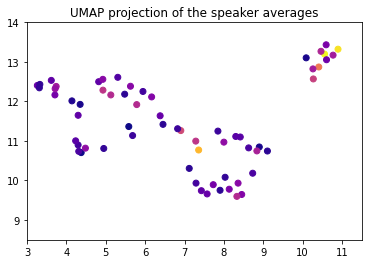

In [86]:
weights = np.array(interruptions_list).reshape(-1,1)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=weights, 
    cmap='plasma')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the speaker averages', fontsize=12)
plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.savefig(f'{current_directory}/UMAP_plots/UMAP.jpg')

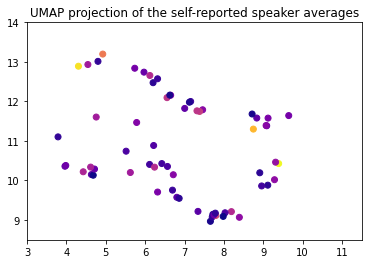

In [87]:
weights = np.array(interruptions_list).reshape(-1,1)
plt.scatter(
    self_report_embedding[:, 0],
    self_report_embedding[:, 1],
    c=weights, 
    cmap='plasma')
plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-reported speaker averages', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_report.jpg')

In [55]:
stability = scaled_average_data[:,1] + scaled_average_data[:,3] + scaled_average_data[:,4]
plasticity = scaled_average_data[:,0] + scaled_average_data[:,2]
stab_plast = np.hstack([stability.reshape(-1,1), plasticity.reshape(-1,1)])
print(stab_plast.shape)

self_stability = scaled_self_report[:,1] + scaled_self_report[:,3] + scaled_self_report[:,4]
self_plasticity = scaled_self_report[:,0] + scaled_self_report[:,2]
self_stab_plast = np.hstack([self_stability.reshape(-1,1), self_plasticity.reshape(-1,1)])



weights = np.array(interruptions_list).reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')

# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: Interruption Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored.jpg')

(64, 2)


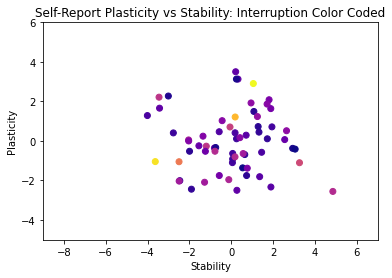

In [56]:
weights = np.array(interruptions_list).reshape(-1,1)
plt.scatter(
    self_stab_plast[:, 0],
    self_stab_plast[:, 1],
    c=weights, 
    cmap='plasma')

# plt.gca().set_aspect('equal', 'datalim')
plt.title('Self-Report Plasticity vs Stability: Interruption Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/self_stability_plasticity_interruption_colored.jpg')

In [ ]:
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

In [57]:
weights = scaled_average_data[:,0].reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: O Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_O_colored.jpg')

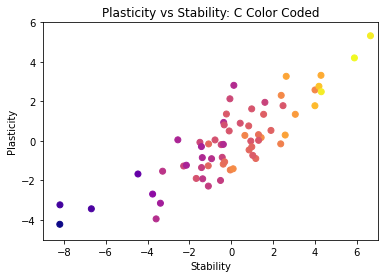

In [58]:
weights = scaled_average_data[:,1].reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: C Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_C_colored.jpg')

In [59]:
weights = scaled_average_data[:,2].reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: E Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_E_colored.jpg')

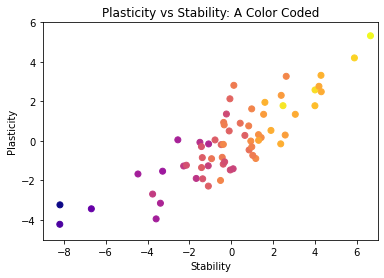

In [60]:
weights = scaled_average_data[:,3].reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: A Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_A_colored.jpg')

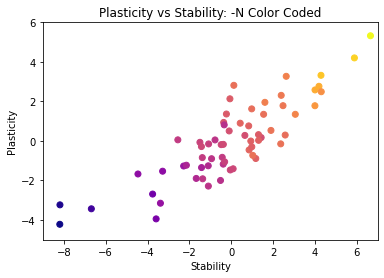

In [61]:
weights = scaled_average_data[:,4].reshape(-1,1)
plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('Plasticity vs Stability: -N Color Coded', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_N_colored.jpg')

# UMAP Plots

In [63]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]
survival_rating_df = pd.read_csv(f'{db_path}/questionnaires/winterSurvivalTask.csv', skiprows=1, sep= '\t')
survival_rating_df.loc[(survival_rating_df['Group'] == 14)]
# survival_rating_df.loc[(survival_rating_df['Group'] == 2) & (survival_rating_df['Letteringroup'] == 'K')]['IndividualTaskperf'].values[0]

Group Letteringroup  TOP1  ...  TOP11.1  TOP12.1  Grouptaskperformance
46     14             K     6  ...       12        2                    42
47     14             L     3  ...       12        2                    42
48     14             M     6  ...       12        2                    42
49     14             N     7  ...       12        2                    42

[4 rows x 28 columns]

In [88]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))

a = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )


b = plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    c= 'k'
    )


plt.legend((a, b),
           ('Projected Averages', 'Projected Self-Report'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages and self-report', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_report_comparison.jpg')

In [89]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("14_K")] = [255, 0, 0]

C[identities_list.index("14_M")] = [0, 255, 0]
C[identities_list.index("14_N")] = [0, 255, 0]
C[identities_list.index("14_L")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )



plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G14', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_14.jpg')

In [90]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("14_K"),:], self_report_embedding[identities_list.index("14_M"),:],
                                self_report_embedding[identities_list.index("14_L"),:], self_report_embedding[identities_list.index("14_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G14', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_14.jpg')

In [69]:
weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("14_K")] = 1

alphas[identities_list.index("14_L")] = 1
alphas[identities_list.index("14_M")] = 1
alphas[identities_list.index("14_N")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 14) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G14 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_14.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("14_K")] = [255, 0, 0]

# C[identities_list.index("14_L")] = [0, 255, 0]
# C[identities_list.index("14_M")] = [0, 255, 0]
# C[identities_list.index("14_N")] = [0, 255, 0]



# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G14', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_14.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("14_K")] = [255, 0, 0]

# C[identities_list.index("14_L")] = [0, 255, 0]
# C[identities_list.index("14_M")] = [0, 255, 0]
# C[identities_list.index("14_N")] = [0, 255, 0]



# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G14', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_14.jpg')


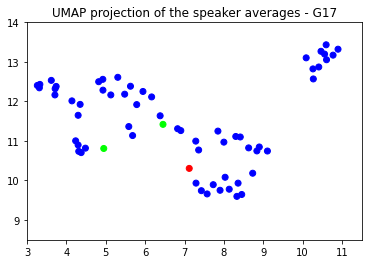

In [91]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("17_M")] = [255, 0, 0]

C[identities_list.index("17_L")] = [0, 255, 0]
C[identities_list.index("17_K")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G17', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_17.jpg')

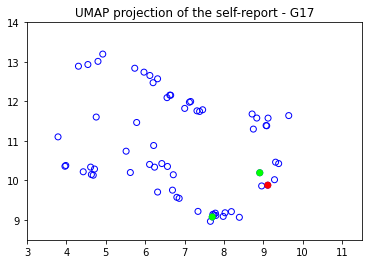

In [92]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("17_M"),:], self_report_embedding[identities_list.index("17_L"),:],
                                self_report_embedding[identities_list.index("17_K"),:]])

C = np.tile(np.array([[0, 255, 0]]), (3, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G17', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_17.jpg')

In [74]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("17_M")] = [255, 0, 0]

# C[identities_list.index("17_L")] = [0, 255, 0]
# C[identities_list.index("17_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G17', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_17.jpg')





weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("17_M")] = 1

alphas[identities_list.index("17_L")] = 1
alphas[identities_list.index("17_K")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 17) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G17 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_17.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("17_K")] = [255, 0, 0]

# C[identities_list.index("17_L")] = [0, 255, 0]
# C[identities_list.index("17_M")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G17', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_17.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("17_K")] = [255, 0, 0]

# C[identities_list.index("17_L")] = [0, 255, 0]
# C[identities_list.index("17_M")] = [0, 255, 0]



# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G17', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_17.jpg')


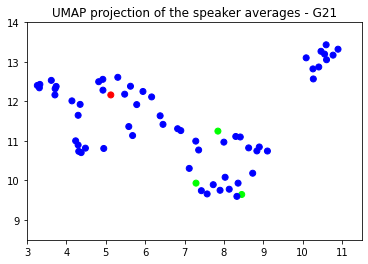

In [93]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("21_N")] = [255, 0, 0]

C[identities_list.index("21_L")] = [0, 255, 0]
C[identities_list.index("21_K")] = [0, 255, 0]
C[identities_list.index("21_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G21', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_21.jpg')

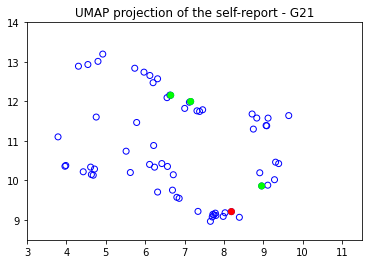

In [94]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("21_N"),:], self_report_embedding[identities_list.index("21_M"),:],
                                self_report_embedding[identities_list.index("21_L"),:], self_report_embedding[identities_list.index("21_K"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G21', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_21.jpg')

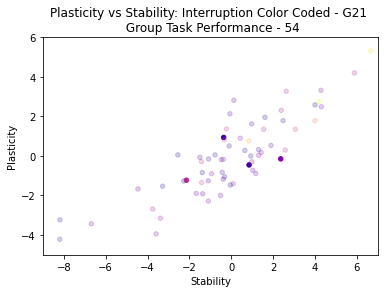

In [79]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("21_N")] = [255, 0, 0]

# C[identities_list.index("21_M")] = [0, 255, 0]
# C[identities_list.index("21_K")] = [0, 255, 0]
# C[identities_list.index("21_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G21', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_21.jpg')




weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("21_N")] = 1

alphas[identities_list.index("21_M")] = 1
alphas[identities_list.index("21_K")] = 1
alphas[identities_list.index("21_L")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 21) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G21 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_21.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("21_M")] = [255, 0, 0]

# C[identities_list.index("21_N")] = [0, 255, 0]
# C[identities_list.index("21_K")] = [0, 255, 0]
# C[identities_list.index("21_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G21', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_21.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("21_L")] = [255, 0, 0]

# C[identities_list.index("21_N")] = [0, 255, 0]
# C[identities_list.index("21_K")] = [0, 255, 0]
# C[identities_list.index("21_M")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G21', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_21.jpg')

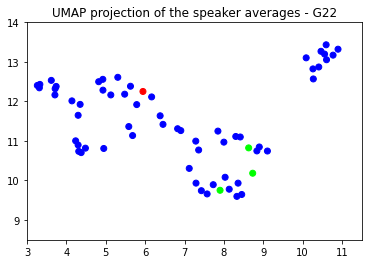

In [95]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("22_N")] = [255, 0, 0]

C[identities_list.index("22_L")] = [0, 255, 0]
C[identities_list.index("22_K")] = [0, 255, 0]
C[identities_list.index("22_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G22', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_22.jpg')

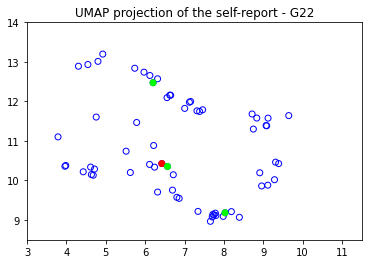

In [96]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("22_N"),:], self_report_embedding[identities_list.index("22_M"),:],
                                self_report_embedding[identities_list.index("22_L"),:], self_report_embedding[identities_list.index("22_K"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G22', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_22.jpg')

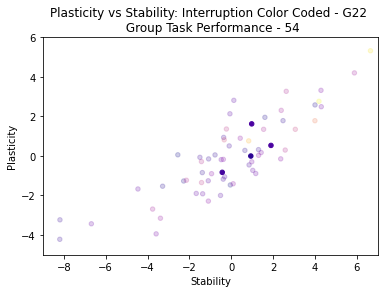

In [99]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("22_N")] = [255, 0, 0]

# C[identities_list.index("22_M")] = [0, 255, 0]
# C[identities_list.index("22_K")] = [0, 255, 0]
# C[identities_list.index("22_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G22', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_22.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("22_N")] = 1

alphas[identities_list.index("22_M")] = 1
alphas[identities_list.index("22_K")] = 1
alphas[identities_list.index("22_L")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 22) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G22 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_22.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("22_N")] = [255, 0, 0]

# C[identities_list.index("22_M")] = [0, 255, 0]
# C[identities_list.index("22_K")] = [0, 255, 0]
# C[identities_list.index("22_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G22', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_22.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("22_K")] = [255, 0, 0]

# C[identities_list.index("22_M")] = [0, 255, 0]
# C[identities_list.index("22_N")] = [0, 255, 0]
# C[identities_list.index("22_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G22', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_22.jpg')

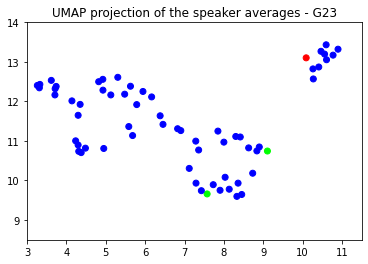

In [100]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("23_K")] = [255, 0, 0]

C[identities_list.index("23_L")] = [0, 255, 0]
C[identities_list.index("23_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])

plt.title('UMAP projection of the speaker averages - G23', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_23.jpg')

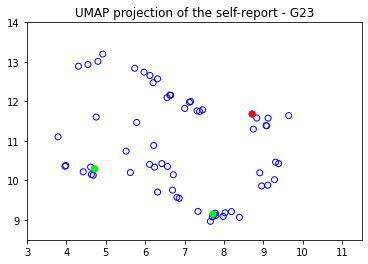

In [101]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("23_K"),:], self_report_embedding[identities_list.index("23_M"),:],
                                self_report_embedding[identities_list.index("23_L"),:]])

C = np.tile(np.array([[0, 255, 0]]), (3, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])

plt.title('UMAP projection of the self-report - G23', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_23.jpg')

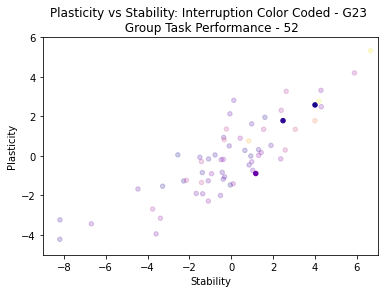

In [104]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("23_K")] = [255, 0, 0]

# C[identities_list.index("23_M")] = [0, 255, 0]
# C[identities_list.index("23_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G23', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_23.jpg')



weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("23_K")] = 1

alphas[identities_list.index("23_L")] = 1
alphas[identities_list.index("23_M")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 23) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G23 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_23.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("23_L")] = [255, 0, 0]

# C[identities_list.index("23_M")] = [0, 255, 0]
# C[identities_list.index("23_K")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G23', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_23.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("23_L")] = [255, 0, 0]

# C[identities_list.index("23_M")] = [0, 255, 0]
# C[identities_list.index("23_K")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G23', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_23.jpg')

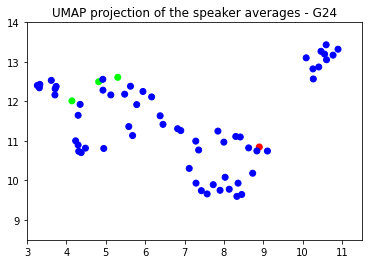

In [105]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("24_L")] = [255, 0, 0]

C[identities_list.index("24_K")] = [0, 255, 0]
C[identities_list.index("24_N")] = [0, 255, 0]
C[identities_list.index("24_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G24', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_24.jpg')

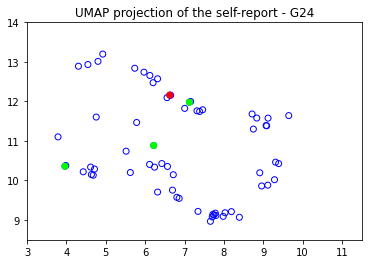

In [106]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("24_L"),:], self_report_embedding[identities_list.index("24_M"),:],
                                self_report_embedding[identities_list.index("24_K"),:], self_report_embedding[identities_list.index("24_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G24', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_24.jpg')

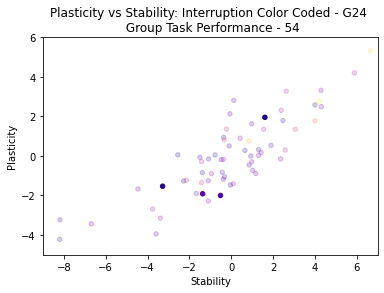

In [109]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("24_L")] = [255, 0, 0]

# C[identities_list.index("24_M")] = [0, 255, 0]
# C[identities_list.index("24_N")] = [0, 255, 0]
# C[identities_list.index("24_K")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G24', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_24.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("24_L")] = 1

alphas[identities_list.index("24_M")] = 1
alphas[identities_list.index("24_N")] = 1
alphas[identities_list.index("24_K")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 24) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G24 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_24.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("24_L")] = [255, 0, 0]

# C[identities_list.index("24_M")] = [0, 255, 0]
# C[identities_list.index("24_K")] = [0, 255, 0]
# C[identities_list.index("24_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G24', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_24.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("24_L")] = [255, 0, 0]

# C[identities_list.index("24_M")] = [0, 255, 0]
# C[identities_list.index("24_K")] = [0, 255, 0]
# C[identities_list.index("24_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G24', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_24.jpg')


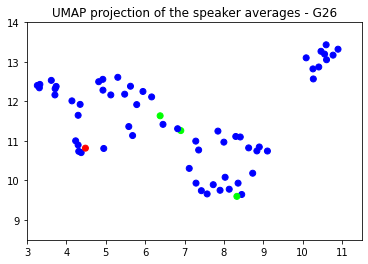

In [110]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("26_L")] = [255, 0, 0]

C[identities_list.index("26_N")] = [0, 255, 0]
C[identities_list.index("26_K")] = [0, 255, 0]
C[identities_list.index("26_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G26', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_26.jpg')

In [111]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("26_L"),:], self_report_embedding[identities_list.index("26_M"),:],
                                self_report_embedding[identities_list.index("26_K"),:], self_report_embedding[identities_list.index("26_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G26', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_26.jpg')

In [114]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("26_L")] = [255, 0, 0]

# C[identities_list.index("26_M")] = [0, 255, 0]
# C[identities_list.index("26_N")] = [0, 255, 0]
# C[identities_list.index("26_K")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G26', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_26.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("26_L")] = 1

alphas[identities_list.index("26_M")] = 1
alphas[identities_list.index("26_N")] = 1
alphas[identities_list.index("26_K")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 26) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G26 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_26.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("26_N")] = [255, 0, 0]

# C[identities_list.index("26_M")] = [0, 255, 0]
# C[identities_list.index("26_L")] = [0, 255, 0]
# C[identities_list.index("26_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G26', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_26.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("26_L")] = [255, 0, 0]

# C[identities_list.index("26_M")] = [0, 255, 0]
# C[identities_list.index("26_N")] = [0, 255, 0]
# C[identities_list.index("26_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G26', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_26.jpg')


In [115]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("28_N")] = [255, 0, 0]

C[identities_list.index("28_L")] = [0, 255, 0]
C[identities_list.index("28_K")] = [0, 255, 0]
C[identities_list.index("28_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G28', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_28.jpg')

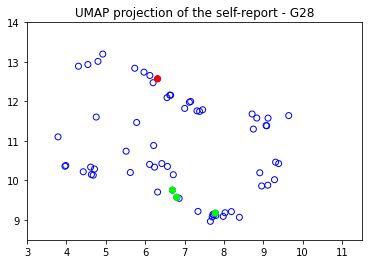

In [116]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("28_N"),:], self_report_embedding[identities_list.index("28_M"),:],
                                self_report_embedding[identities_list.index("28_L"),:], self_report_embedding[identities_list.index("28_K"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G28', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_28.jpg')

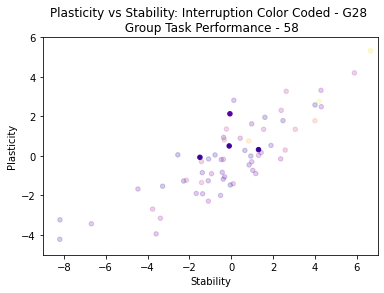

In [119]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("28_N")] = [255, 0, 0]

# C[identities_list.index("28_M")] = [0, 255, 0]
# C[identities_list.index("28_K")] = [0, 255, 0]
# C[identities_list.index("28_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G28', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_28.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("28_N")] = 1

alphas[identities_list.index("28_M")] = 1
alphas[identities_list.index("28_K")] = 1
alphas[identities_list.index("28_L")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 28) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G28 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_28.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("28_L")] = [255, 0, 0]

# C[identities_list.index("28_M")] = [0, 255, 0]
# C[identities_list.index("28_K")] = [0, 255, 0]
# C[identities_list.index("28_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G28', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_28.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("28_K")] = [255, 0, 0]

# C[identities_list.index("28_M")] = [0, 255, 0]
# C[identities_list.index("28_L")] = [0, 255, 0]
# C[identities_list.index("28_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G28', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_28.jpg')


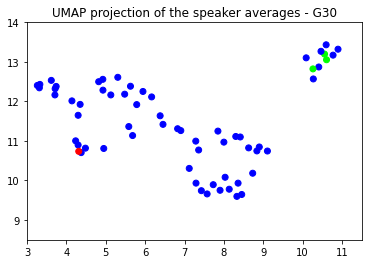

In [120]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("30_K")] = [255, 0, 0]

C[identities_list.index("30_N")] = [0, 255, 0]
C[identities_list.index("30_L")] = [0, 255, 0]
C[identities_list.index("30_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G30', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_30.jpg')

In [121]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("30_K"),:], self_report_embedding[identities_list.index("30_M"),:],
                                self_report_embedding[identities_list.index("30_L"),:], self_report_embedding[identities_list.index("30_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G30', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_30.jpg')

In [125]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("30_K")] = [255, 0, 0]

# C[identities_list.index("30_M")] = [0, 255, 0]
# C[identities_list.index("30_N")] = [0, 255, 0]
# C[identities_list.index("30_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G30', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_30.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("30_K")] = 1

alphas[identities_list.index("30_L")] = 1
alphas[identities_list.index("30_M")] = 1
alphas[identities_list.index("30_N")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 30) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G30 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_30.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("30_K")] = [255, 0, 0]

# C[identities_list.index("30_M")] = [0, 255, 0]
# C[identities_list.index("30_L")] = [0, 255, 0]
# C[identities_list.index("30_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G30', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_30.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("30_M")] = [255, 0, 0]

# C[identities_list.index("30_K")] = [0, 255, 0]
# C[identities_list.index("30_L")] = [0, 255, 0]
# C[identities_list.index("30_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G30', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_30.jpg')


In [126]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("36_M")] = [255, 0, 0]

C[identities_list.index("36_K")] = [0, 255, 0]
C[identities_list.index("36_L")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])

plt.title('UMAP projection of the speaker averages - G36', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_36.jpg')

In [127]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("36_M"),:], self_report_embedding[identities_list.index("36_K"),:],
                                self_report_embedding[identities_list.index("36_L"),:]])

C = np.tile(np.array([[0, 255, 0]]), (3, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])

plt.title('UMAP projection of the self-report - G36', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_36.jpg')

In [130]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("36_M")] = [255, 0, 0]

# C[identities_list.index("36_K")] = [0, 255, 0]
# C[identities_list.index("36_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G36', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_36.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("36_M")] = 1

alphas[identities_list.index("36_K")] = 1
alphas[identities_list.index("36_L")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 36) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G36 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_36.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("36_M")] = [255, 0, 0]

# C[identities_list.index("36_L")] = [0, 255, 0]
# C[identities_list.index("36_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G36', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_36.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("36_L")] = [255, 0, 0]

# C[identities_list.index("36_M")] = [0, 255, 0]
# C[identities_list.index("36_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G36', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_36.jpg')


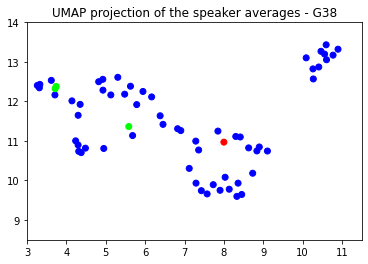

In [131]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("38_K")] = [255, 0, 0]

C[identities_list.index("38_N")] = [0, 255, 0]
C[identities_list.index("38_L")] = [0, 255, 0]
C[identities_list.index("38_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G38', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_38.jpg')

In [132]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("38_K"),:], self_report_embedding[identities_list.index("38_M"),:],
                                self_report_embedding[identities_list.index("38_L"),:], self_report_embedding[identities_list.index("38_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G38', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_38.jpg')

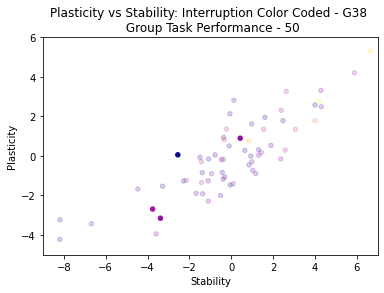

In [135]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("38_K")] = [255, 0, 0]

# C[identities_list.index("38_M")] = [0, 255, 0]
# C[identities_list.index("38_N")] = [0, 255, 0]
# C[identities_list.index("38_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G38', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_38.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("38_K")] = 1

alphas[identities_list.index("38_L")] = 1
alphas[identities_list.index("38_M")] = 1
alphas[identities_list.index("38_N")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 38) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G38 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_38.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("38_M")] = [255, 0, 0]

# C[identities_list.index("38_L")] = [0, 255, 0]
# C[identities_list.index("38_K")] = [0, 255, 0]
# C[identities_list.index("38_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G38', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_38.jpg')




# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("38_M")] = [255, 0, 0]

# C[identities_list.index("38_L")] = [0, 255, 0]
# C[identities_list.index("38_K")] = [0, 255, 0]
# C[identities_list.index("38_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G38', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_38.jpg')


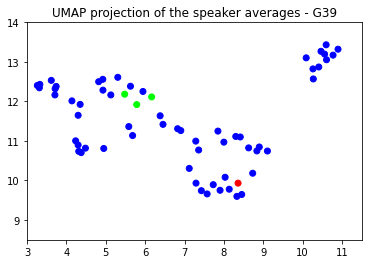

In [136]:
C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("39_K")] = [255, 0, 0]

C[identities_list.index("39_N")] = [0, 255, 0]
C[identities_list.index("39_L")] = [0, 255, 0]
C[identities_list.index("39_M")] = [0, 255, 0]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = C/255.0 )

plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the speaker averages - G39', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/UMAP_39.jpg')

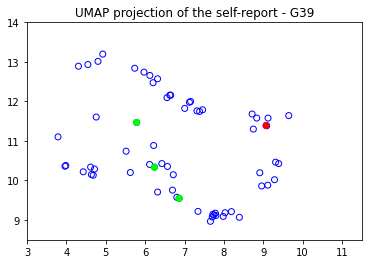

In [137]:
plt.scatter(
    self_report_embedding[:,0],
    self_report_embedding[:,1],
    marker='o', 
    facecolors='none', 
    edgecolors='b'
    )

self_report_points = np.vstack([self_report_embedding[identities_list.index("39_K"),:], self_report_embedding[identities_list.index("39_M"),:],
                                self_report_embedding[identities_list.index("39_L"),:], self_report_embedding[identities_list.index("39_N"),:]])

C = np.tile(np.array([[0, 255, 0]]), (4, 1))
C[0,:] = [255, 0, 0]


plt.scatter(
    self_report_points[:,0],
    self_report_points[:,1],
    c= C/255.0
    )


plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('UMAP projection of the self-report - G39', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/UMAP_self_39.jpg')

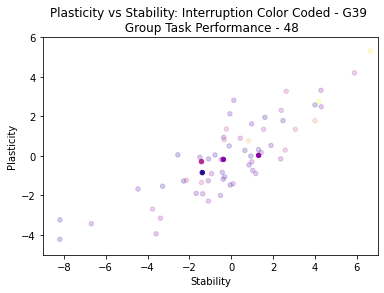

In [140]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("39_K")] = [255, 0, 0]

# C[identities_list.index("39_M")] = [0, 255, 0]
# C[identities_list.index("39_N")] = [0, 255, 0]
# C[identities_list.index("39_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G39', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_39.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("39_K")] = 1

alphas[identities_list.index("39_L")] = 1
alphas[identities_list.index("39_M")] = 1
alphas[identities_list.index("39_N")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 39) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G39 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_39.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("39_M")] = [255, 0, 0]

# C[identities_list.index("39_L")] = [0, 255, 0]
# C[identities_list.index("39_K")] = [0, 255, 0]
# C[identities_list.index("39_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G39', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_39.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("39_M")] = [255, 0, 0]

# C[identities_list.index("39_L")] = [0, 255, 0]
# C[identities_list.index("39_K")] = [0, 255, 0]
# C[identities_list.index("39_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G39', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_39.jpg')


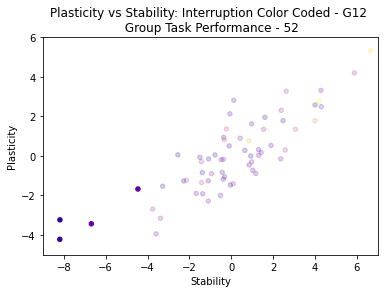

In [143]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("12_K")] = [0, 255, 0]
# C[identities_list.index("12_M")] = [0, 255, 0]
# C[identities_list.index("12_N")] = [0, 255, 0]
# C[identities_list.index("12_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G12', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/extra/stability_plasticity_12.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("12_K")] = 1

alphas[identities_list.index("12_L")] = 1
alphas[identities_list.index("12_M")] = 1
alphas[identities_list.index("12_N")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 12) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G12 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_12.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("12_K")] = [255, 0, 0]

# C[identities_list.index("12_L")] = [0, 255, 0]
# C[identities_list.index("12_M")] = [0, 255, 0]
# C[identities_list.index("12_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G12', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_12.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("12_K")] = [255, 0, 0]

# C[identities_list.index("12_L")] = [0, 255, 0]
# C[identities_list.index("12_M")] = [0, 255, 0]
# C[identities_list.index("12_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G12', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_12.jpg')

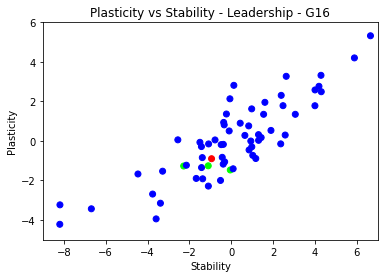

In [146]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("16_K")] = [0, 255, 0]
# C[identities_list.index("16_M")] = [0, 255, 0]
# C[identities_list.index("16_N")] = [0, 255, 0]
# C[identities_list.index("16_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G16', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/extra/stability_plasticity_16.jpg')

# weights = np.array(interruptions_list).reshape(-1,1)

# alphas = 0.2 * np.ones(stab_plast.shape[0])
# alphas[identities_list.index("16_K")] = 1

# alphas[identities_list.index("16_L")] = 1
# alphas[identities_list.index("16_M")] = 1
# alphas[identities_list.index("16_N")] = 1

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c=weights, 
#     cmap='plasma',
#     s=20, 
#     alpha=alphas)

# # plt.gca().set_aspect('equal', 'datalim')
# survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 16) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
# plt.title(f'Plasticity vs Stability: Interruption Color Coded - G16 \n Group Task Performance - {survival_rating}', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_16.jpg')


C[identities_list.index("16_K")] = [255, 0, 0]

C[identities_list.index("16_L")] = [0, 255, 0]
C[identities_list.index("16_M")] = [0, 255, 0]
C[identities_list.index("16_N")] = [0, 255, 0]


plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c = C/255.0 )

plt.title('Plasticity vs Stability - Leadership - G16', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_16.jpg')




# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("16_K")] = [255, 0, 0]

# C[identities_list.index("16_L")] = [0, 255, 0]
# C[identities_list.index("16_M")] = [0, 255, 0]
# C[identities_list.index("16_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G16', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_16.jpg')

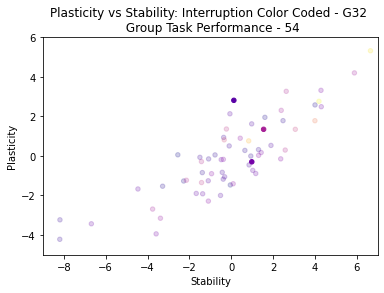

In [149]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("32_K")] = [0, 255, 0]
# C[identities_list.index("32_M")] = [0, 255, 0]
# C[identities_list.index("32_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G32', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/extra/stability_plasticity_32.jpg')

weights = np.array(interruptions_list).reshape(-1,1)

alphas = 0.2 * np.ones(stab_plast.shape[0])
alphas[identities_list.index("32_K")] = 1

alphas[identities_list.index("32_L")] = 1
alphas[identities_list.index("32_M")] = 1

plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c=weights, 
    cmap='plasma',
    s=20, 
    alpha=alphas)

# plt.gca().set_aspect('equal', 'datalim')
survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 32) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
plt.title(f'Plasticity vs Stability: Interruption Color Coded - G32 \n Group Task Performance - {survival_rating}', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_32.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("32_L")] = [255, 0, 0]

# C[identities_list.index("32_M")] = [0, 255, 0]
# C[identities_list.index("32_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Dominance - G32', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_32.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("32_L")] = [255, 0, 0]

# C[identities_list.index("32_M")] = [0, 255, 0]
# C[identities_list.index("32_K")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G32', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_32.jpg')

In [152]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("34_K")] = [0, 255, 0]
# C[identities_list.index("34_M")] = [0, 255, 0]
# C[identities_list.index("34_N")] = [0, 255, 0]
# C[identities_list.index("34_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G34', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/extra/stability_plasticity_34.jpg')

# weights = np.array(interruptions_list).reshape(-1,1)

# alphas = 0.2 * np.ones(stab_plast.shape[0])
# alphas[identities_list.index("34_K")] = 1

# alphas[identities_list.index("34_L")] = 1
# alphas[identities_list.index("34_M")] = 1
# alphas[identities_list.index("34_N")] = 1

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c=weights, 
#     cmap='plasma',
#     s=20, 
#     alpha=alphas)

# # plt.gca().set_aspect('equal', 'datalim')
# survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 34) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
# plt.title(f'Plasticity vs Stability: Interruption Color Coded - G34 \n Group Task Performance - {survival_rating}', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_34.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("34_L")] = [255, 0, 0]

# C[identities_list.index("34_M")] = [0, 255, 0]
# C[identities_list.index("34_K")] = [0, 255, 0]
# C[identities_list.index("34_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G34', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_34.jpg')



C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("34_L")] = [255, 0, 0]

C[identities_list.index("34_M")] = [0, 255, 0]
C[identities_list.index("34_K")] = [0, 255, 0]
C[identities_list.index("34_N")] = [0, 255, 0]


plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c = C/255.0 )

plt.title('Plasticity vs Stability - Dominance - G34', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_34.jpg')

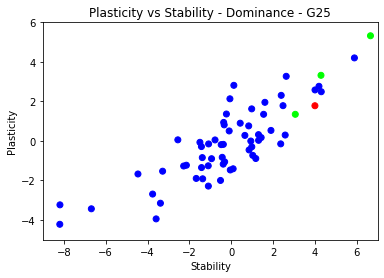

In [155]:
# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("25_K")] = [0, 255, 0]
# C[identities_list.index("25_M")] = [0, 255, 0]
# C[identities_list.index("25_N")] = [0, 255, 0]
# C[identities_list.index("25_L")] = [0, 255, 0]

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - G25', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')
# plt.savefig(f'{current_directory}/stability_plasticity/extra/stability_plasticity_25.jpg')

# weights = np.array(interruptions_list).reshape(-1,1)

# alphas = 0.2 * np.ones(stab_plast.shape[0])
# alphas[identities_list.index("25_K")] = 1

# alphas[identities_list.index("25_L")] = 1
# alphas[identities_list.index("25_M")] = 1
# alphas[identities_list.index("25_N")] = 1

# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c=weights, 
#     cmap='plasma',
#     s=20, 
#     alpha=alphas)

# # plt.gca().set_aspect('equal', 'datalim')
# survival_rating = survival_rating_df.loc[(survival_rating_df['Group'] == 25) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
# plt.title(f'Plasticity vs Stability: Interruption Color Coded - G25 \n Group Task Performance - {survival_rating}', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')

# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_interruption_colored_25.jpg')


# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
# C[identities_list.index("25_M")] = [255, 0, 0]

# C[identities_list.index("25_L")] = [0, 255, 0]
# C[identities_list.index("25_K")] = [0, 255, 0]
# C[identities_list.index("25_N")] = [0, 255, 0]


# plt.scatter(
#     stab_plast[:, 0],
#     stab_plast[:, 1],
#     c = C/255.0 )

# plt.title('Plasticity vs Stability - Leadership - G25', fontsize=12)
# plt.xlabel('Stability')
# plt.ylabel('Plasticity')

# plt.xlim([-9, 7])
# plt.ylim([-5, 6])
# plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_leadership_25.jpg')



# C = np.tile(np.array([[0, 0, 255]]), (embedding.shape[0], 1))
C[identities_list.index("25_N")] = [255, 0, 0]

C[identities_list.index("25_L")] = [0, 255, 0]
C[identities_list.index("25_K")] = [0, 255, 0]
C[identities_list.index("25_M")] = [0, 255, 0]


plt.scatter(
    stab_plast[:, 0],
    stab_plast[:, 1],
    c = C/255.0 )

plt.title('Plasticity vs Stability - Dominance - G25', fontsize=12)
plt.xlabel('Stability')
plt.ylabel('Plasticity')

plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_dominance_25.jpg')

# Clusters

In [156]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(embedding)

clusters_dict = {0:[], 1:[], 2:[]}
for idx, label in enumerate(kmeans.labels_):
  clusters_dict[label].append(identities_list[idx])

plt.scatter(embedding[kmeans.labels_ == 0, 0], embedding[kmeans.labels_ == 0, 1], c="red")
plt.scatter(embedding[kmeans.labels_ == 1, 0],embedding[kmeans.labels_ == 1, 1], c="blue")
plt.scatter(embedding[kmeans.labels_ == 2, 0],embedding[kmeans.labels_ == 2, 1], c="green")
plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('KMeans Clustering of the UMAP projections of Speaker Averages', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_plots/KMeans.jpg')

In [ ]:
!cp -r {current_directory}/UMAP_plots/KMeans.jpg {db_path}}/UMAP_plots/KMeans.jpg

In [ ]:
interrupt_indicies = np.argpartition(np.array(interruptions_list), -7)[-7:]

# interrupt_indicies = interrupt_indicies[np.argsort(np.array(interruptions_list)[interrupt_indicies])]
# print(interrupt_indicies)

hot_identities = [identities_list[i] for i in list(set(np.nonzero(kmeans.labels_ == 1)[0]) & set(interrupt_indicies))]
hot_identities

['25_L', '30_N', '25_K', '25_N']

In [ ]:
print('Cluster 1')
print(f'{clusters_dict[0]}\n')

print('Cluster 2')
print(f'{clusters_dict[1]}\n')

print('Cluster 3')
print(f'{clusters_dict[2]}\n')

Cluster 1
['12_K', '12_L', '12_M', '12_N', '14_M', '14_N', '14_L', '16_K', '16_L', '16_N', '16_M', '17_L', '21_N', '22_N', '24_K', '24_M', '24_N', '26_L', '26_K', '28_N', '30_K', '36_K', '36_L', '38_L', '38_M', '38_N', '39_M', '39_L', '39_N']

Cluster 2
['23_K', '25_K', '25_N', '25_L', '25_M', '30_N', '30_L', '30_M', '34_M', '34_L']

Cluster 3
['14_K', '17_M', '17_K', '21_L', '21_K', '21_M', '22_K', '22_L', '22_M', '23_L', '23_M', '24_L', '26_M', '26_N', '28_L', '28_K', '28_M', '32_L', '32_M', '32_K', '34_N', '34_K', '36_M', '38_K', '39_K']



In [ ]:
cluster_avg_dict = {}
for key, id_list in clusters_dict.items():
  vals = []
  for id in id_list:
    vals.append(averages_list[identities_list.index(id)])
  mat = np.vstack(vals)
  cluster_avg_dict[key] = np.mean(mat, axis=0)

print('Cluster 1')
print(f'{cluster_avg_dict[0]}\n')

print('Cluster 2')
print(f'{cluster_avg_dict[1]}\n')

print('Cluster 3')
print(f'{cluster_avg_dict[2]}\n')

Cluster 1
[0.52072631 0.43088503 0.41138748 0.53009232 0.44964812]

Cluster 2
[0.60117688 0.49675554 0.51300814 0.56887703 0.51910066]

Cluster 3
[0.55748175 0.45406155 0.46495666 0.55443743 0.48458697]



# Self-Report Clusters

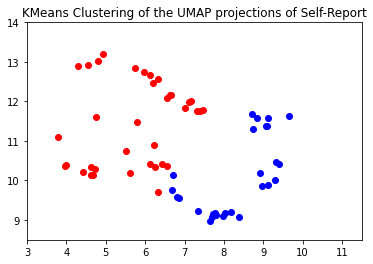

In [158]:
from sklearn.cluster import KMeans
kmeans_self = KMeans(n_clusters=2, random_state=0).fit(self_report_embedding)

clusters_dict_self = {0:[], 1:[], 2:[]}
for idx, label in enumerate(kmeans_self.labels_):
  clusters_dict_self[label].append(identities_list[idx])

plt.scatter(self_report_embedding[kmeans_self.labels_ == 0, 0], self_report_embedding[kmeans_self.labels_ == 0, 1], c="red")
plt.scatter(self_report_embedding[kmeans_self.labels_ == 1, 0],self_report_embedding[kmeans_self.labels_ == 1, 1], c="blue")
plt.scatter(self_report_embedding[kmeans_self.labels_ == 2, 0],self_report_embedding[kmeans_self.labels_ == 2, 1], c="green")
plt.xlim([3,11.5])
plt.ylim([8.5,14])
plt.title('KMeans Clustering of the UMAP projections of Self-Report', fontsize=12)
plt.savefig(f'{current_directory}/UMAP_self_report_plots/KMeans.jpg')

In [ ]:
print('Cluster 1')
print(f'{clusters_dict_self[0]}\n')

print('Cluster 2')
print(f'{clusters_dict_self[1]}\n')

print('Cluster 3')
print(f'{clusters_dict_self[2]}\n')

Cluster 1
['12_L', '12_M', '14_K', '14_N', '14_L', '16_N', '17_M', '17_K', '21_L', '21_K', '21_M', '22_K', '22_L', '22_N', '22_M', '23_M', '24_L', '24_N', '25_N', '25_M', '26_M', '26_N', '26_K', '28_L', '28_K', '28_M', '30_K', '32_L', '32_K', '34_N', '34_K', '34_M', '38_L', '38_M', '38_K', '38_N', '39_M', '39_N']

Cluster 2
['12_K', '12_N', '14_M', '16_K', '16_L', '16_M', '17_L', '21_N', '23_L', '23_K', '24_K', '24_M', '25_L', '26_L', '28_N', '30_N', '30_M', '32_M', '34_L', '36_K', '36_M', '39_K', '39_L']

Cluster 3
['25_K', '30_L', '36_L']



In [159]:
self_stab_plast_design_matrix = self_stab_plast.transpose()
covariance_matrix = (1/self_stab_plast.shape[0]) * self_stab_plast_design_matrix @ self_stab_plast_design_matrix.transpose()

w, v = np.linalg.eig(covariance_matrix)

# V is a matrix formed by the eigenvectors of A (as columns)
# C_tilde is w checks out well!

C_tilde = v.transpose() @ covariance_matrix @ v
C_tilde_inv =  v.transpose() @ np.linalg.inv(covariance_matrix) @ v

mean = np.mean(self_stab_plast, axis=0)

In [160]:
random_points = np.random.multivariate_normal(mean, C_tilde, 100)
random_points = random_points @ v.transpose()

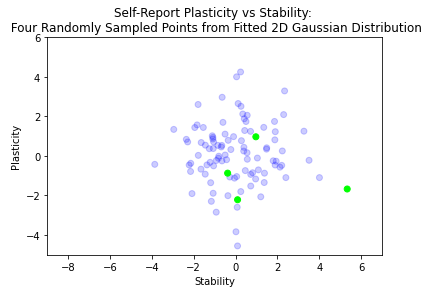

In [161]:
C = np.tile(np.array([[0, 0, 255]]), (random_points.shape[0], 1))
alphas = 0.2 * np.ones(random_points.shape[0])

for i in np.random.choice(random_points.shape[0], 4, replace=False):
  C[i,:] = [0, 255, 0]
  alphas[i] = 1

plt.scatter(
    random_points[:, 0],
    random_points[:, 1],
    c = C/255.0,
    alpha=alphas)

plt.title(f'Self-Report Plasticity vs Stability: \n Four Randomly Sampled Points from Fitted 2D Gaussian Distribution')
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/self_stability_plasticity_distribution.jpg')

In [162]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]

stab_plast_avgs = []
for group in groups:
  group_avg  = []

  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
  
  for idx in matching_idxs:
    group_avg.append(self_stab_plast[idx])

  stab_plast_avgs.append(np.mean(np.vstack(group_avg), axis=0))

std_actual_points = np.std(np.vstack(stab_plast_avgs), axis=0)

gen_stab_plast_avgs = []
for i in range(100):
  random_points = np.random.multivariate_normal(mean, C_tilde, 4)
  random_points = random_points @ v.transpose()
  gen_stab_plast_avgs.append(np.mean(random_points, axis=0))


std_gen_points = np.std(np.vstack(gen_stab_plast_avgs), axis=0)

print(std_actual_points)
print(std_gen_points)

[1.04320595 0.47350402]
[0.97637774 0.72480913]


In [163]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]

stab_plast_std = []
for group in groups:
  group_points = []
  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
  
  for idx in matching_idxs:
    group_points.append(self_stab_plast[idx])
  
  group_avg = np.mean(np.vstack(group_points), axis=0)
  stab_plast_std.append(np.std(np.abs(np.vstack(group_points) - group_avg), axis=0))


avg_actual_points = np.mean(np.vstack(stab_plast_std), axis=0)




gen_stab_plast_std = []
for i in range(100):
  random_points = np.random.multivariate_normal(mean, C_tilde, 4)
  random_points = random_points @ v.transpose()

  group_avg = np.mean(np.vstack(random_points), axis=0)
  gen_stab_plast_std.append(np.std(np.abs(np.vstack(random_points) - group_avg), axis=0))

avg_gen_points = np.mean(np.vstack(gen_stab_plast_std), axis=0)

print(avg_actual_points)
print(avg_gen_points)

[0.69195163 0.60605657]
[0.67761804 0.57313897]


# Leadership and Dominance

No relation btwn lead and dominance max in group and group outlier in UMAP clusters

In [ ]:
lead_dom = np.vstack(dom_lead_list)

In [ ]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]


for group in groups:
  group_pts  = []
  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
      group_pts.append(lead_dom[idx])

  group_vec = np.vstack(group_pts)
  max_id = np.argmax(group_vec, axis = 0)

  max_elea_id = identities_list[matching_idxs[max_id[0]]]
  


  print(max_elea_id)

12_K
14_K
16_K
17_K
21_L
22_K
23_L
24_L
25_M
26_L
28_K
30_M
32_L
34_L
36_L
38_M
39_M


# Fitter

In [ ]:
!pip install fitter

     |████████████████████████████████| 47 kB 3.7 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=07aff1b9a44b3de8587b2b5152a6dcc6a5110c9a1c6dc71f04df2ce6a77b64ae
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=f3fe15899097220d070bcdb264355823b0f6ca0da20e504ea614f7bcad8b98eb
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
# f = Fitter(height,
#            distributions=['gamma',
#                           'lognorm',
#                           "beta",
#                           "burr",
#                           "norm"])

In [ ]:
embedding[:,1]

array([12.404114 , 12.532365 , 12.343965 , 12.430759 , 12.285249 ,
        9.7795315, 11.649337 , 10.8980465, 12.384291 , 11.003449 ,
       11.925334 , 10.705498 , 10.810126 , 10.306092 , 11.419867 ,
       12.164347 ,  9.646285 , 11.249319 ,  9.933457 , 10.184054 ,
        9.752486 , 12.252047 , 10.82501  ,  9.6601925, 10.745557 ,
       13.102701 , 12.498937 , 12.61003  , 10.8478775, 12.014117 ,
       13.321212 , 12.871031 , 12.568795 , 13.432599 , 10.818227 ,
        9.598399 , 11.262505 , 11.636959 , 11.113643 , 11.136903 ,
       10.081814 , 11.309603 , 13.197351 , 12.82286  , 10.737651 ,
       13.054275 ,  9.894245 , 10.747937 , 11.100626 , 10.771393 ,
       10.996057 , 13.170712 , 13.26785  , 12.559    ,  9.742386 ,
       12.164417 , 12.379581 , 12.321692 , 10.970275 , 11.364705 ,
       11.920074 ,  9.933094 , 12.113995 , 12.183255 ], dtype=float32)

sumsquare_error         aic         bic  kl_div
gausshyper          2.406167  423.751052 -185.020988     inf
kappa4              2.440300  415.788595 -192.437231     inf
bradford            2.459784  416.154551 -196.087168     inf
beta                2.460451  415.794952 -191.910935     inf
tukeylambda         2.463847  412.582892 -195.981535     inf

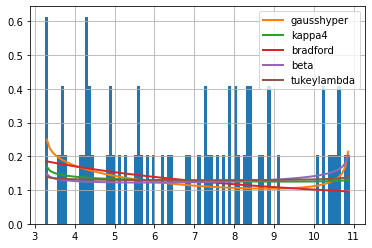

In [ ]:
f_emb1 = Fitter(embedding[:,0])
f_emb1.fit()
f_emb1.summary()

In [ ]:
f_emb1.get_best(method = 'sumsquare_error')

{'gausshyper': {'a': 0.9077620600424496,
  'b': 0.7678862684882439,
  'c': 1.1369983354381876,
  'loc': 3.2632533584723067,
  'scale': 7.634288476414055,
  'z': 1.2211932363294222}}

sumsquare_error         aic         bic  kl_div
dgamma               10.376152  328.433570 -103.963223     inf
dweibull             10.382390  311.948373 -103.924756     inf
kappa4               10.439503  277.762553  -99.414776     inf
vonmises_line        10.459090  274.851440 -103.453695     inf
tukeylambda          10.464500  274.819095 -103.420598     inf

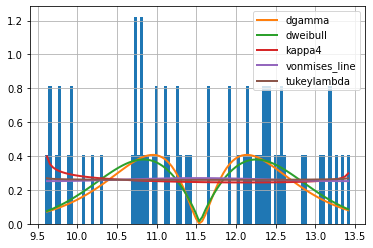

In [ ]:
f_emb2 = Fitter(embedding[:,1])
f_emb2.fit()
f_emb2.summary()

In [ ]:
em2_outliers_identities = [identities_list[i] for i in list(set(np.nonzero(embedding[:,1] > 13)[0]) | set(np.nonzero(embedding[:,1] < 10.5)[0]))]
em2_outliers_identities

['14_K',
 '17_M',
 '21_L',
 '21_M',
 '22_K',
 '22_L',
 '23_L',
 '23_K',
 '25_K',
 '25_M',
 '26_M',
 '28_K',
 '30_N',
 '30_M',
 '32_L',
 '34_M',
 '34_L',
 '36_M',
 '39_K']

In [ ]:
embedding[:,1] > 13.0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
f_emb2.get_best(method = 'sumsquare_error')

{'dgamma': {'a': 2.612186395778422,
  'loc': 11.543335816267849,
  'scale': 0.36679007807857816}}

In [ ]:
stab = Fitter(stab_plast[:,0])
stab.fit()
stab.summary()

sumsquare_error         aic         bic  kl_div
dgamma                6.211486  419.481662 -136.802258     inf
dweibull              6.276491  415.038637 -136.135960     inf
vonmises_line         6.436149  405.568035 -134.528321     inf
t                     6.462570  420.221255 -134.266138     inf
fisk                  6.463215  418.719880 -134.259746     inf

In [ ]:
stab.get_best(method = 'sumsquare_error')

{'dgamma': {'a': 1.4771035704645268,
  'loc': 1.5555555888297655e-15,
  'scale': 0.5215001796475366}}

In [ ]:
stab_outliers_identities = [identities_list[i] for i in list(set(np.nonzero(stab_plast[:,0] > 1)[0]) | set(np.nonzero(stab_plast[:,0] < -1)[0]))]
stab_outliers_identities

['12_K',
 '12_L',
 '12_M',
 '12_N',
 '14_K',
 '21_L',
 '23_M',
 '25_K',
 '25_N',
 '25_L',
 '26_M',
 '28_N',
 '30_N',
 '30_M',
 '32_K',
 '34_M',
 '38_M',
 '38_N',
 '39_M']

sumsquare_error         aic         bic  kl_div
laplace              1.799260  545.700370 -220.258733     inf
burr                 1.799707  537.060035 -211.925047     inf
gennorm              1.810525  535.039840 -215.700401     inf
skewnorm             1.811499  528.598666 -215.665973     inf
norminvgauss         1.812135  531.260034 -211.484606     inf

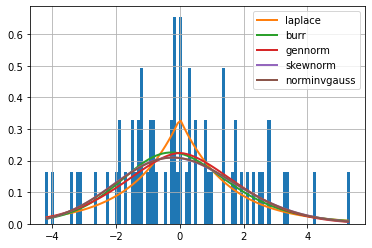

In [ ]:
plast = Fitter(stab_plast[:,1])
plast.fit()
plast.summary()

In [ ]:
plast.get_best(method = 'sumsquare_error')

{'laplace': {'loc': 5.2115209798466945e-16, 'scale': 1.5026851939250556}}

In [ ]:
for i in stab_outliers_identities:
  if i in em2_outliers_identities:
    print(i)

14_K
21_L
25_K
26_M
30_N
30_M
34_M


# Spread

In [ ]:
embedding_spread_list = []
stab_plast_spread_list = []
for group_id in groups:
  try:
    stab_plast_spread_list.append(np.std(np.vstack([stab_plast[identities_list.index(f"{group_id}_K")], stab_plast[identities_list.index(f"{group_id}_M")], stab_plast[identities_list.index(f"{group_id}_N")], stab_plast[identities_list.index(f"{group_id}_L")]]), axis=0))
    embedding_spread_list.append(np.std(np.vstack([embedding[identities_list.index(f"{group_id}_K")], embedding[identities_list.index(f"{group_id}_M")], embedding[identities_list.index(f"{group_id}_N")], embedding[identities_list.index(f"{group_id}_L")]]), axis=0))
  except:
    stab_plast_spread_list.append(np.std(np.vstack([stab_plast[identities_list.index(f"{group_id}_K")], stab_plast[identities_list.index(f"{group_id}_M")], stab_plast[identities_list.index(f"{group_id}_L")]]), axis=0))
    embedding_spread_list.append(np.std(np.vstack([embedding[identities_list.index(f"{group_id}_K")], embedding[identities_list.index(f"{group_id}_M")], embedding[identities_list.index(f"{group_id}_L")]]), axis=0))

embedding_spread = np.vstack(embedding_spread_list)
stab_plast_spread = np.vstack(stab_plast_spread_list)

In [ ]:
embedding_spread[:,0] > stab_plast_spread[:,0]

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True])

In [ ]:
embedding_spread

array([[0.1388955 , 0.06806611],
       [1.5909677 , 0.93270504],
       [0.5685156 , 0.67834157],
       [0.90767205, 0.45537856],
       [1.2535069 , 1.0166875 ],
       [1.1186503 , 0.94565487],
       [1.0346498 , 1.4370112 ],
       [1.8406528 , 0.6979343 ],
       [0.23497348, 0.34767652],
       [1.3772668 , 0.7673361 ],
       [1.042555  , 0.48438853],
       [2.6703694 , 0.9993509 ],
       [0.45661664, 0.50646204],
       [1.651666  , 1.1709802 ],
       [1.547612  , 1.245224  ],
       [1.7537601 , 0.60813236],
       [1.1299796 , 0.93137366]], dtype=float32)

# Stability and Plasticity Gaussian

In [164]:
stab_plast_design_matrix = stab_plast.transpose()
covariance_matrix = (1/stab_plast.shape[0]) * stab_plast_design_matrix @ stab_plast_design_matrix.transpose()

w, v = np.linalg.eig(covariance_matrix)

# V is a matrix formed by the eigenvectors of A (as columns)
# C_tilde is w checks out well!

C_tilde = v.transpose() @ covariance_matrix @ v
C_tilde_inv =  v.transpose() @ np.linalg.inv(covariance_matrix) @ v

mean = np.mean(stab_plast, axis=0)

In [165]:
random_points = np.random.multivariate_normal(mean, C_tilde, 100)
random_points = random_points @ v.transpose()

In [169]:
C = np.tile(np.array([[0, 0, 255]]), (random_points.shape[0], 1))
alphas = 0.2 * np.ones(random_points.shape[0])

for i in np.random.choice(random_points.shape[0], 4, replace=False):
  C[i,:] = [0, 255, 0]
  alphas[i] = 1

plt.scatter(
    random_points[:, 0],
    random_points[:, 1],
    c = C/255.0,
    alpha=alphas)

plt.title(f'Plasticity vs Stability: \n Four Randomly Sampled Points from Fitted 2D Gaussian Distribution')
plt.xlabel('Stability')
plt.ylabel('Plasticity')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
plt.savefig(f'{current_directory}/stability_plasticity/stability_plasticity_distribution.jpg')

In [170]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]

stab_plast_avgs = []
for group in groups:
  group_avg  = []

  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
  
  for idx in matching_idxs:
    group_avg.append(stab_plast[idx])

  stab_plast_avgs.append(np.mean(np.vstack(group_avg), axis=0))

std_actual_points = np.std(np.vstack(stab_plast_avgs), axis=0)

gen_stab_plast_avgs = []
for i in range(100):
  random_points = np.random.multivariate_normal(mean, C_tilde, 4)
  random_points = random_points @ v.transpose()
  gen_stab_plast_avgs.append(np.mean(random_points, axis=0))


std_gen_points = np.std(np.vstack(gen_stab_plast_avgs), axis=0)

print(std_actual_points)
print(std_gen_points)

[2.39464549 1.55215159]
[1.35754306 0.95568541]


In [171]:
groups = [12,14,16,17,21,22,23,24,25,26,28,30,32,34,36,38,39]

stab_plast_std = []
for group in groups:
  group_points = []
  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
  
  for idx in matching_idxs:
    group_points.append(stab_plast[idx])
  
  group_avg = np.mean(np.vstack(group_points), axis=0)
  stab_plast_std.append(np.std(np.abs(np.vstack(group_points) - group_avg), axis=0))


avg_actual_points = np.mean(np.vstack(stab_plast_std), axis=0)




gen_stab_plast_std = []
for i in range(100):
  random_points = np.random.multivariate_normal(mean, C_tilde, 4)
  random_points = random_points @ v.transpose()

  group_avg = np.mean(np.vstack(random_points), axis=0)
  gen_stab_plast_std.append(np.std(np.abs(np.vstack(random_points) - group_avg), axis=0))

avg_gen_points = np.mean(np.vstack(gen_stab_plast_std), axis=0)

print(avg_actual_points)
print(avg_gen_points)

[0.72557851 0.49453956]
[1.13505182 0.78225381]


# Ellipses Plot

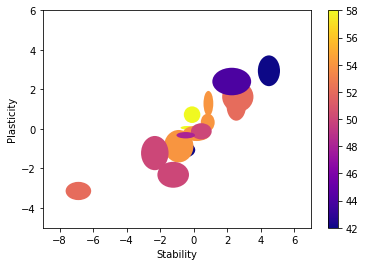

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

survival_rating_df = pd.read_csv(f"{db_path}/questionnaires/winterSurvivalTask.csv", skiprows=1, sep= '\t')

stab_plast_std = []
ellipses = []
group_ratings = []
for group in groups:
  group_points = []
  matching_idxs = []
  for idx, id in enumerate(identities_list):
    if int(re.findall(r'\d+', id)[0]) == group:
      matching_idxs.append(idx)
  
  for idx in matching_idxs:
    group_points.append(stab_plast[idx])
  
  group_avg = np.mean(np.vstack(group_points), axis=0)
  group_std = np.std(np.vstack(group_points), axis=0)
  ellipse = Ellipse(xy=group_avg, width=group_std[0], height=group_std[1])
  ellipses.append(ellipse)
  survival_rating  = survival_rating_df.loc[(survival_rating_df['Group'] == group) & (survival_rating_df['Letteringroup'] == 'K')]['Grouptaskperformance'].values[0]
  group_ratings.append(survival_rating)


fig, ax = plt.subplots()

# plt.figure()
# ax = plt.gca()

col = PatchCollection(ellipses, array=group_ratings, cmap='plasma')
plt.xlim([-9, 7])
plt.ylim([-5, 6])
ax.set_xlabel('Stability')
ax.set_ylabel('Plasticity')
ax.add_collection(col)
fig.colorbar(col)
plt.show()
fig.savefig(f'{current_directory}/stability_plasticity/ellipse_plot.jpg') 

# https://stackoverflow.com/questions/65631607/showing-different-size-circles-in-heatmap-with-legend-using-matplotlib
# https://stackoverflow.com/questions/10952060/plot-ellipse-with-matplotlib-pyplot-python

In [174]:
!cp -r {current_directory}/UMAP_plots/ {db_path}/UMAP_plots/
!cp -r {current_directory}/UMAP_self_report_plots/ {db_path}/UMAP_self_report_plots/
# !cp -r {current_directory}/stability_plasticity/ {db_path}/stability_plasticity/
!cp -r {current_directory}/stability_plasticity/ {db_path}/stability_plasticity_2/